In [1]:
import pickle
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# Loading Data 

In [2]:
path='../Data/traffic_data/'
label=pd.read_csv(path+'labels.csv')
train=pd.read_csv(path+'Train.csv')
label.head()

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


Text(0, 0.5, 'Label')

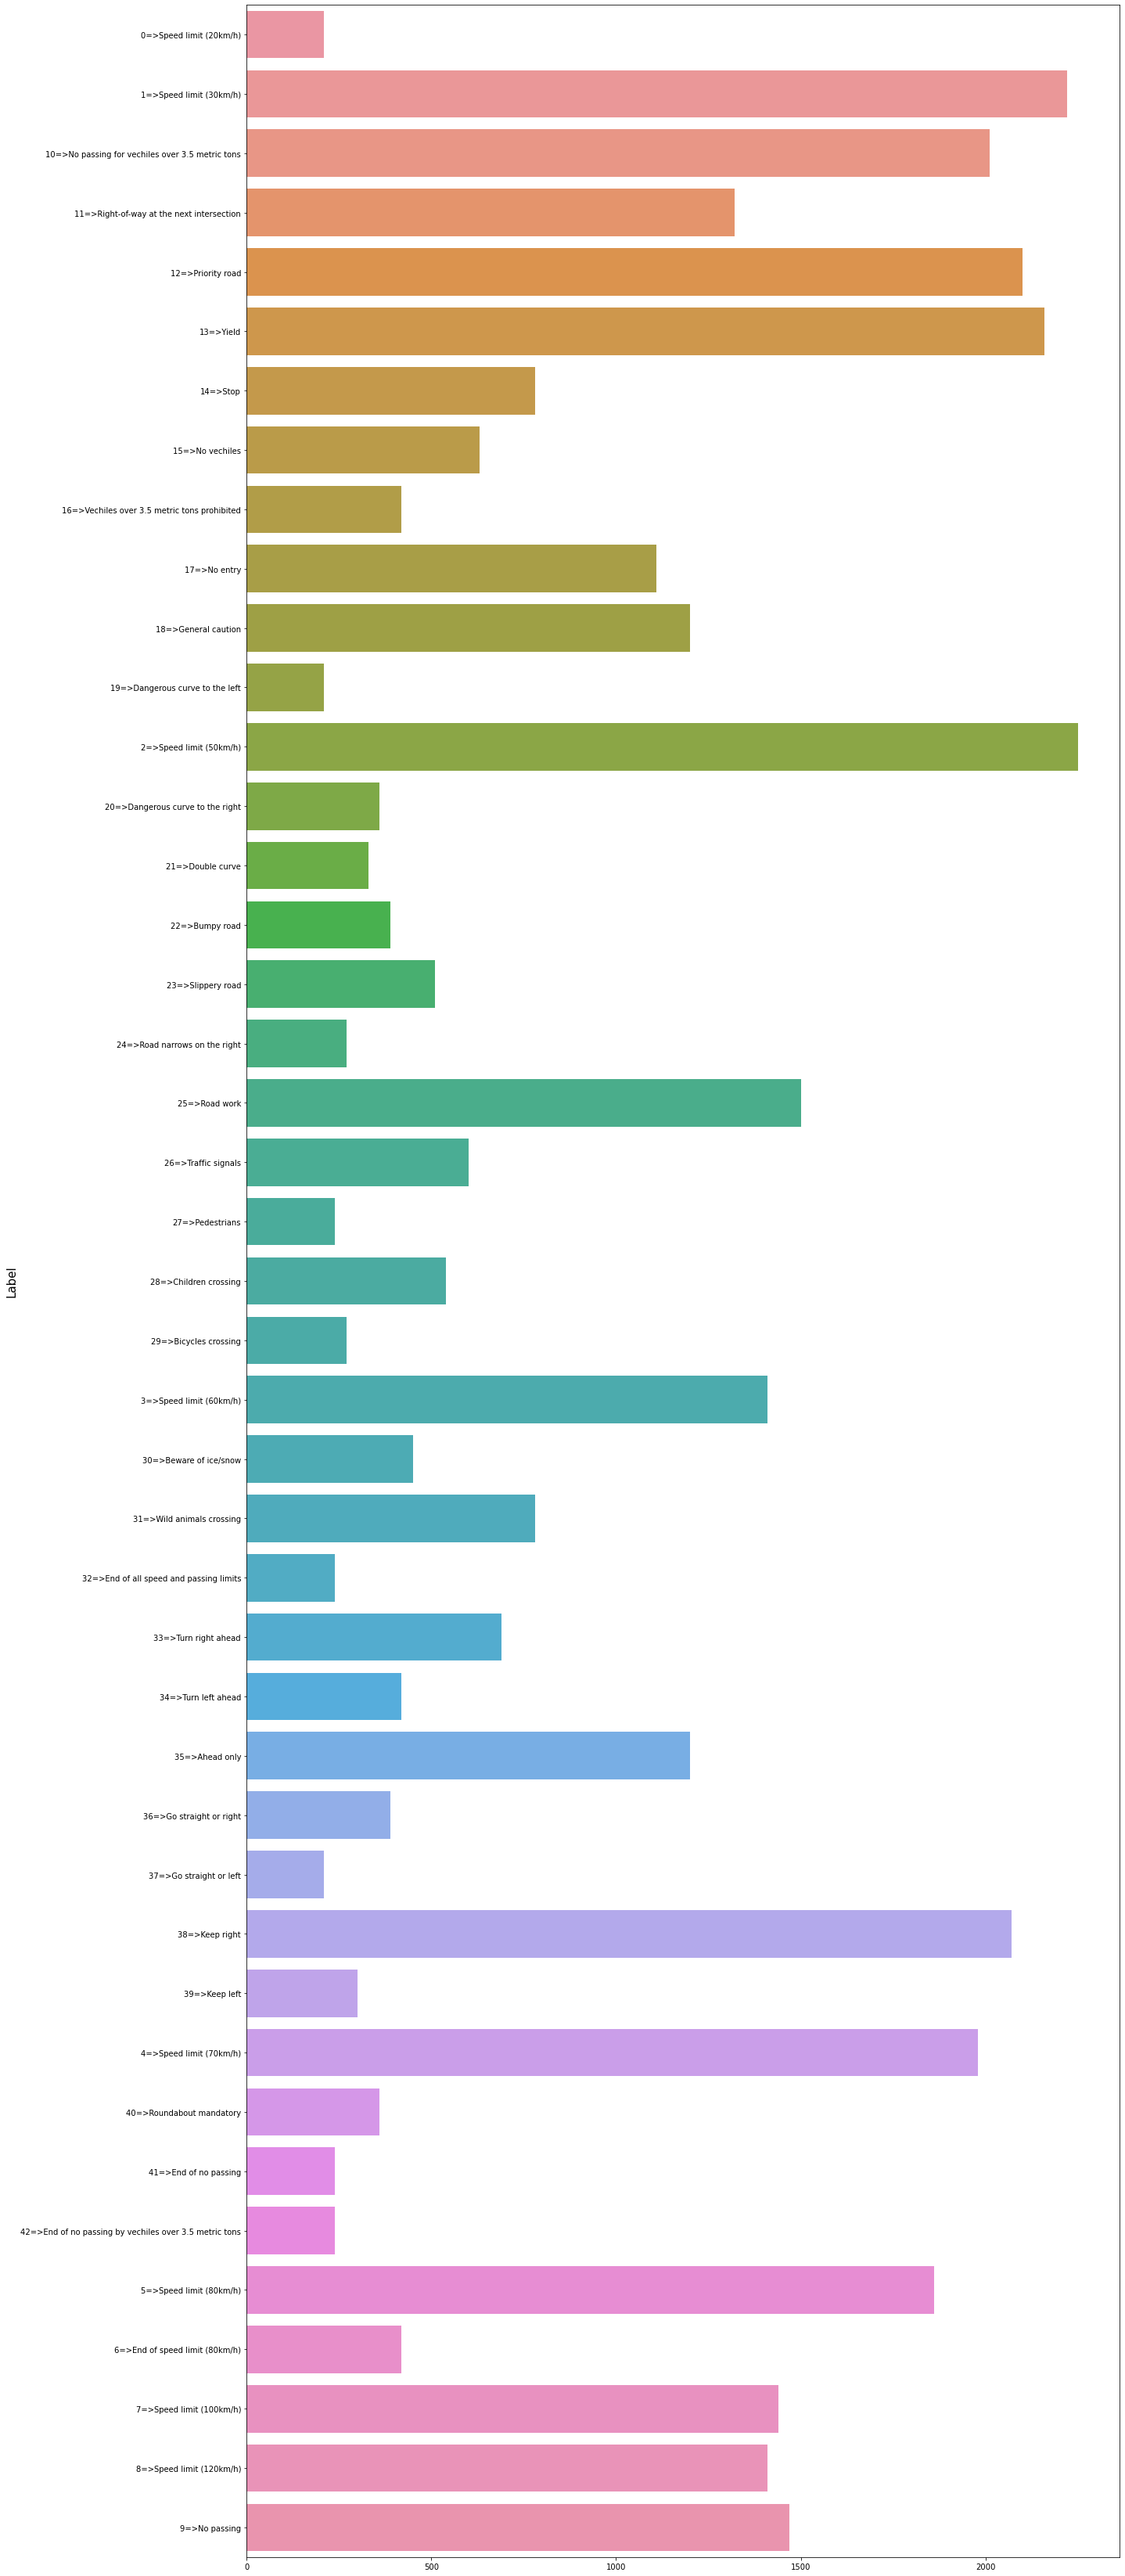

In [3]:
d=dict()
class_labels=dict()
for dirs in os.listdir(path+'Train/'):
    count=len(os.listdir(path+'Train/'+dirs))
    d[dirs+'=>'+label[label.ClassId == int(dirs)].values[0][1]]=count
    class_labels[int(dirs)]=label[label.ClassId==int(dirs)].values[0][1]
plt.figure(figsize=(20,60))
sns.barplot(y=list(d.keys()),x=list(d.values()))
plt.ylabel('Label',fontsize=15)

In [4]:
data=pd.DataFrame(d.values(), columns=['count'])
data.sum()

count    39209
dtype: int64

In [10]:
data=pd.DataFrame({'Label':list(d.keys()),
                    'Count':list(d.values())})
data['Label_nums']=data['Label'].apply(lambda num:num.split('=>')[0])
data['Labels']=data['Label'].apply(lambda label:label.split('=>')[1])
data.drop(['Label'], axis=1, inplace=True)
move=data.pop('Count')
data.insert(2,'Count',move)

# Encode Image to array

In [6]:
img_rows,img_cols=25,25
img_chanels=3
nb_classes=len(class_labels.keys())

datagen=ImageDataGenerator()
data_train=datagen.flow_from_directory(path+'Train',
                                target_size=(25,25),
                                batch_size=39204,
                                class_mode='categorical',
                                shuffle=True)


Found 39209 images belonging to 43 classes.


In [7]:
X,y=data_train.next()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=11)

# Designing Deep CNN model

In [8]:
model=Sequential()
model.add(layers.experimental.preprocessing.RandomContrast(0.85, input_shape=(25,25,3)))
model.add(layers.experimental.preprocessing.RandomZoom(0.2))
model.add(Conv2D(200,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(400,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(600,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(400,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(43,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast (RandomContr (None, 25, 25, 3)         0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 25, 25, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 23, 200)       5600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 400)         720400    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 400)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 600)         2

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
early_stop=EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=25)
model.fit(X_train,y_train,epochs=25, validation_data=(X_test,y_test))

Epoch 1/25
981/981 [==============================] - 273s 277ms/step - loss: 1.6587 - accuracy: 0.6064 - val_loss: 0.4340 - val_accuracy: 0.8694
Epoch 2/25
981/981 [==============================] - 270s 275ms/step - loss: 0.4739 - accuracy: 0.8721 - val_loss: 0.2900 - val_accuracy: 0.9186
Epoch 3/25
981/981 [==============================] - 295s 301ms/step - loss: 0.3994 - accuracy: 0.8970 - val_loss: 0.2154 - val_accuracy: 0.9440
Epoch 4/25
981/981 [==============================] - 266s 271ms/step - loss: 0.3091 - accuracy: 0.9163 - val_loss: 0.2198 - val_accuracy: 0.9515
Epoch 5/25
981/981 [==============================] - 280s 286ms/step - loss: 0.2799 - accuracy: 0.9238 - val_loss: 0.1657 - val_accuracy: 0.9575
Epoch 6/25
981/981 [==============================] - 268s 274ms/step - loss: 0.2480 - accuracy: 0.9334 - val_loss: 0.1782 - val_accuracy: 0.9498
Epoch 7/25
981/981 [==============================] - 257s 262ms/step - loss: 0.3081 - accuracy: 0.9262 - val_loss: 0.1905 -

# Validation Accuracies

<AxesSubplot:>

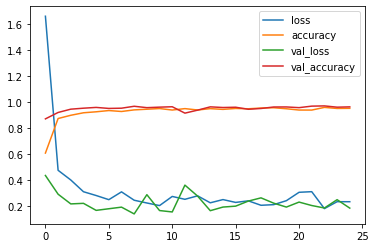

In [11]:
data_model=pd.DataFrame(model.history.history)
data_model.plot()

In [14]:
predict=model.predict(X_test)
model.evaluate(X_test,y_test)
model

246/246 [==============================] - 8s 33ms/step - loss: 0.1830 - accuracy: 0.9617


# Classification Report

In [15]:
y_predict=[np.argmax(element) for element in predict]
print(classification_report(np.argmax(y_test,axis=1), y_predict))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        36
           1       0.96      0.93      0.94       415
           2       1.00      0.99      0.99       411
           3       0.93      0.99      0.96       254
           4       1.00      1.00      1.00       450
           5       1.00      0.99      1.00       452
           6       1.00      0.99      0.99       149
           7       0.97      0.95      0.96       122
           8       1.00      1.00      1.00        77
           9       1.00      1.00      1.00       222
          10       0.96      0.96      0.96       255
          11       0.95      0.93      0.94        42
          12       0.98      0.93      0.96       458
          13       0.98      0.84      0.91        70
          14       0.83      0.97      0.89        61
          15       1.00      1.00      1.00        83
          16       0.98      0.95      0.97       109
          17       0.93    

# Confusion Matrix

<AxesSubplot:>

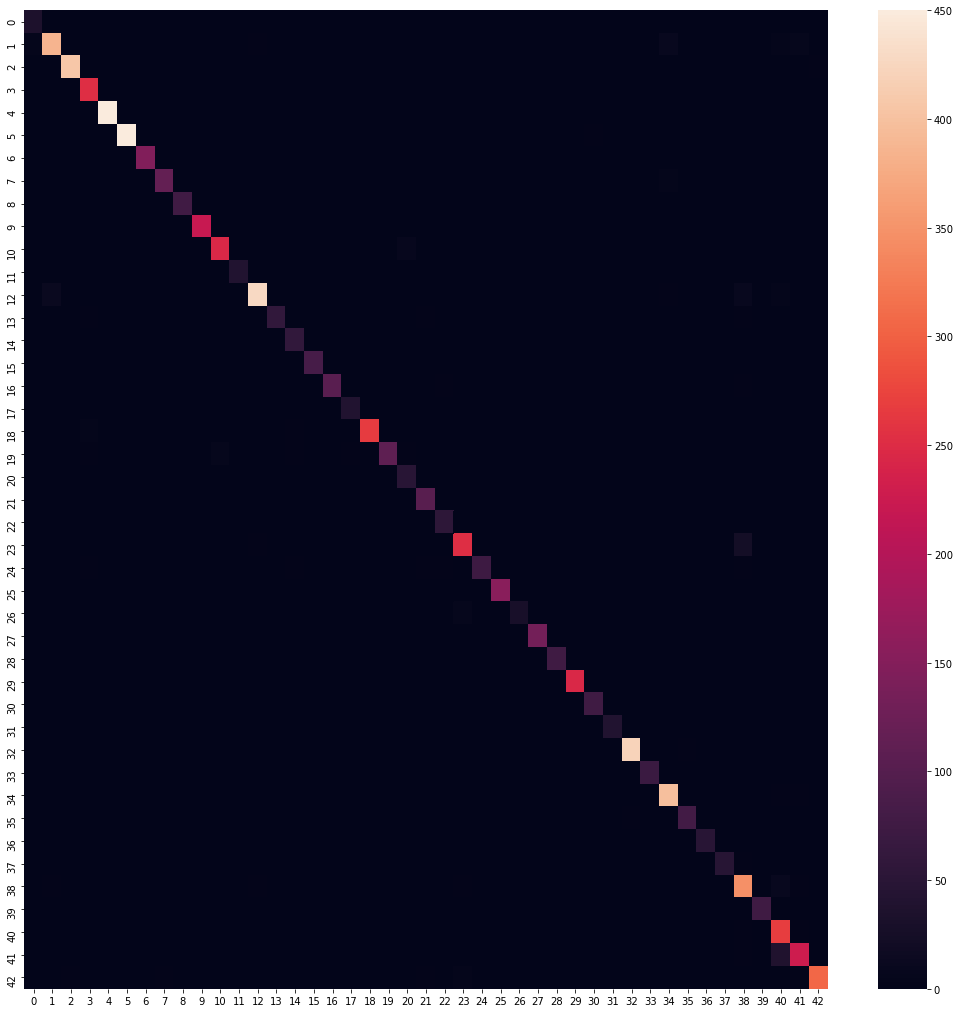

In [16]:
plt.figure(figsize=(18,18))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1),y_predict))

# Save Prediction model

In [18]:
tf.keras.models.save_model(model,'Model Predict Traffic Sign 2')
check_image=tf.keras.models.load_model('Model Predict Traffic Sign 2')

INFO:tensorflow:Assets written to: Model Predict Traffic Sign 2\assets


# Testing on one image 

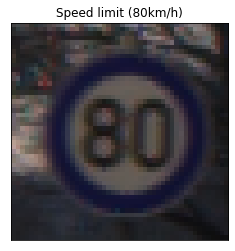

In [34]:
def checker(img):
    img=np.array(img)
    img=cv2.resize(img,(25,25))
    img=np.array(img).reshape(-1,25,25,3)
    return np.argmax(check_image.predict(img))
def print_name(img):
    for i in range(len(d)):
        if data.index[i]==checker(img):
            return data['Labels'][i]
img=cv2.imread(path+'Test/00074.png')
plt.imshow(img)
plt.title(print_name(img))
plt.grid(False)
plt.xticks([])
plt.yticks([]);

# Testing on many images

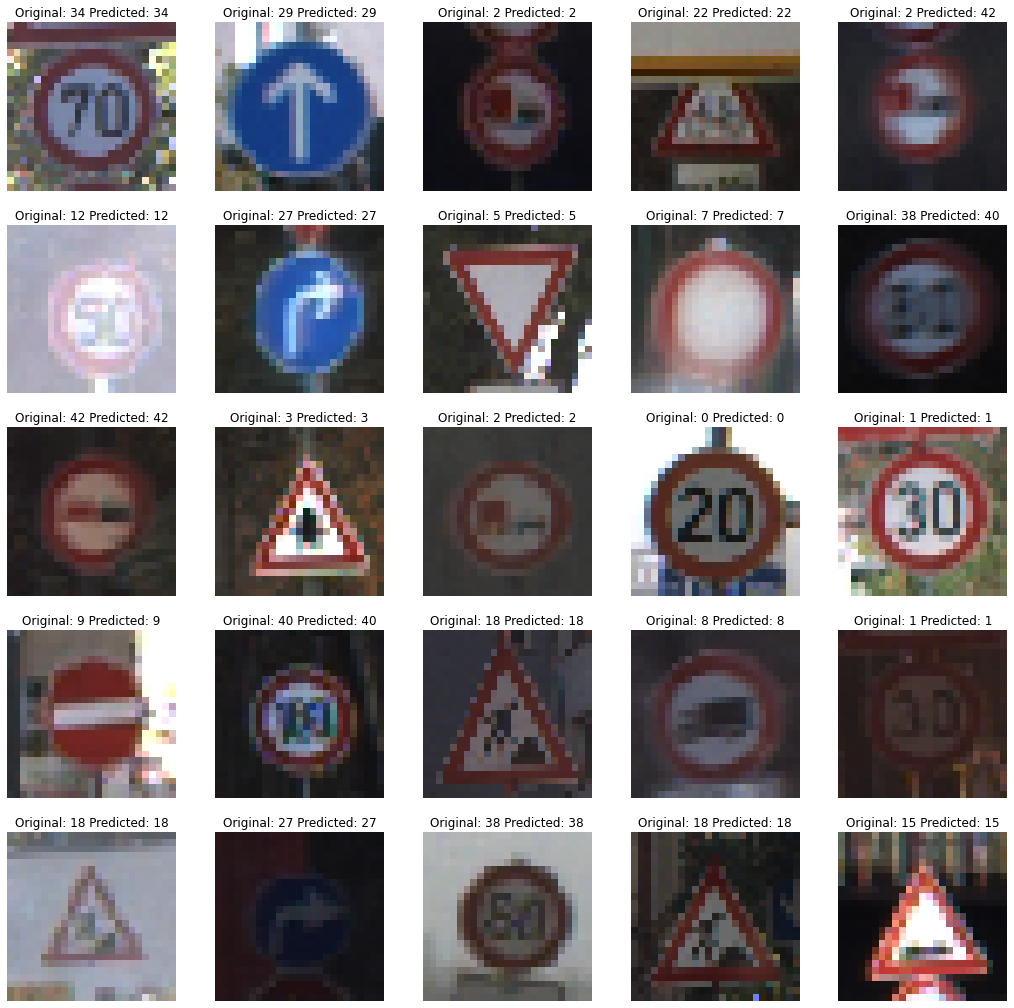

In [178]:
fig,axes=plt.subplots(5,5,figsize=(18,18))
for i, ax in enumerate(axes.flat):
    r=np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 25, 25, 3)))))